# Recommender Systems Workshop
*Presented by Stefan Dominicus at Deep Learning IndabaX 2025.*

# Part 1: Aggregation
In this notebook, we explore an excerpt of Takealot.com's product reviews, and use it to build a simple "Top Rated" product recommendation mechanism.

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

DATA = Path.cwd().parent / "data"

# Customers leave star-ratings for products (1-5 stars).
MAX_RATING = 5
RATING_BINS = [i + 0.5 for i in range(MAX_RATING + 1)]

# Exploratory Data Analysis
Before we can build anything, we need to understand what data we have to work with. Understanding your data, and the systems that produce it, is critically important in any machine learning project.

## Explore Products
To begin with, load the `products.csv` dataset, and see what it contains.

In [ ]:
products = pd.read_csv(DATA / "products.csv")

products.head(10)

If you want to know more about a product, you can view the product page on Takealot.com. Just set the `product_id` for the one you're interested in.

In [ ]:
product_id = "PLID95234247"

print(f"https://takealot.com/abc/{product_id}")

Let's get a sense of distribution of produces across brands and departments

In [ ]:
products.groupby("product_brand", sort=False, dropna=False).size().sort_values(
    ascending=False
).to_frame()

In [ ]:
products.groupby("product_department", sort=False, dropna=False).size().sort_values(
    ascending=False
).plot.bar()
plt.title("Number of products per department")
plt.xlabel("Department")
plt.ylabel("Number of products")

plt.show()

## Explore Reviews
Next, load the `reviews.csv` dataset, and see what it contains.

In [ ]:
reviews = pd.read_csv(DATA / "reviews.csv")

reviews.head(10)

Let's plot the distribution of ⭐️ ratings.

In [ ]:
reviews[["review_rating"]].plot.hist(bins=RATING_BINS)
plt.title("Distribution of review ratings")
plt.xlabel("Rating")

plt.show()

This shows that the majority of reviews left by our customers are positive (4 or 5 ⭐️). Yay!

What about our customers? Let's see how many products each of them has reviewed.

In [ ]:
reviews.groupby("customer_id", sort=False).aggregate(
    product_id_count=("product_id", "count")
).plot.hist(bins=[10 - 0.5 + i for i in range(12)])
plt.title("Distribution of review counts per customer")
plt.xlabel("Number of reviews")

plt.show()

We see that in this dataset, all customers have submitted between 10 and 20 reviews. What might you infer about our customer's from this bimodal distribution?

Now consider all the reviews of each product. Let's compute the average rating, and number of reviews, and plot those distributions.

In [ ]:
review_aggregation_by_product = reviews.groupby("product_id", sort=False).aggregate(
    review_rating_mean=("review_rating", "mean"),
    review_rating_count=("review_rating", "count"),
)

review_aggregation_by_product[["review_rating_mean"]].plot.hist(bins=RATING_BINS)
plt.title("Distribution of average review ratings per product")
plt.xlabel("Rating")
review_aggregation_by_product[["review_rating_count"]].plot.hist(log=True)
plt.title("Distribution of review counts per product")
plt.xlabel("Number of reviews")

plt.show()

# Generate Recommendations

In [ ]:
product_ratings = products.merge(
    review_aggregation_by_product, left_on="product_id", right_index=True
).set_index("product_id")

product_ratings.head(10)

## Top Rated Products (Overall)

In [ ]:
# Show top rated products
product_ratings.sort_values(by="review_rating_mean", ascending=False).head(10)

In [ ]:
# Now think about tie-breaking
product_ratings.sort_values(
    by=["review_rating_mean", "review_rating_count"], ascending=False
).head(10)

In [ ]:
# TODO[IndabaX]: Ignore for now, we'll come back to this later

## Top Rated Products (By Brand)

In [ ]:
# Show top rated products (with tie-breaking)
product_ratings[product_ratings["product_brand"] == "BLACK+DECKER"].sort_values(
    by=["review_rating_mean", "review_rating_count"], ascending=False
).head(10)

In [ ]:
# TODO[IndabaX]: Ignore for now, we'll come back to this later

## Top Rated Products (By Department)

In [ ]:
# Show top rated products (with tie-breaking)
product_ratings[
    product_ratings["product_department"] == "Computers & Tablets"
].sort_values(by=["review_rating_mean", "review_rating_count"], ascending=False).head(
    10
)

In [ ]:
# TODO[IndabaX]: Ignore for now, we'll come back to this later

## *What happens if a product has a 4.9⭐️ average rating from 50 reviews?*

# A better way to order products by rating
As a shopper, how confident can you be that a product's mean rating will be representative of _your_ individual experience?

## Laplace Rule of Succession
> If we repeat an experiment that we know can result in a success or failure, _n_ times independently, and get _s_ successes, and _n − s_ failures, then what is the probability that the next repetition will succeed?

Links:
 - Wikipedia page: https://en.wikipedia.org/wiki/Rule_of_succession
 - 3 Blue 1 Brown YouTube series: https://www.youtube.com/watch?v=8idr1WZ1A7Q

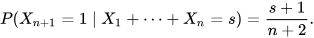

This rule is expressed for binary experiments (where the result is either a success or a failure). We make a few assumptions in order to apply this rule to our product ratings:
 - `s` (the number of previous successes for each product) is modeled as the mean rating multiplied by the number of reviews.
 - A 5 ⭐️ rating is considered to be the most "successful" interaction.
 - `n` is simply the number of previous reviews for each product.

In [ ]:
# Compute the expected rating using Laplace Rule of Succession
product_ratings["review_rating_expected"] = (
    (product_ratings["review_rating_mean"] * product_ratings["review_rating_count"])
    + MAX_RATING
) / (product_ratings["review_rating_count"] + 2)

After applying this rule to our product ratings, we are left with a "expected" rating for each product.

In [ ]:
# Look at the effect of this transformation
product_ratings[["review_rating_mean"]].plot.hist(bins=RATING_BINS)
plt.title("Distribution of average review ratings per product (mean)")
plt.xlabel("Rating")
product_ratings[["review_rating_expected"]].plot.hist(bins=RATING_BINS)
plt.title("Distribution of expected review ratings per product (Laplace)")
plt.xlabel("Rating")

plt.show()

## Now go back and generate recommendations using this new 'expected' rating